[[130.84251375]]
[[204.51888281]]


<ipython-input-2-86a6514aace2>:246: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a, b, th = np.asscalar(x[0:1,:].reshape(1,)), np.asscalar(x[1:2,:].reshape(1,)), np.asscalar(x[2:3,:].reshape(1,))


(-2.0, 2.0, -2.0, 2.0)

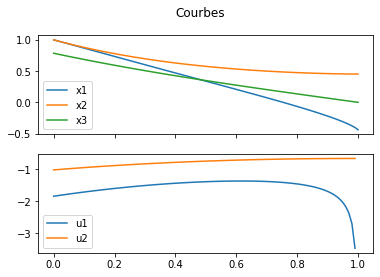

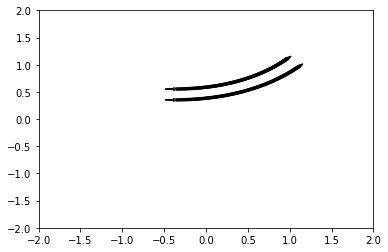

In [2]:
from numpy import linalg
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def jacobian(f):
    """
    Returns the jacobian matrix of a function f at a given point x
    usage :
    
    def myfunction(x): #x has to be an (n,1) array
        return np.concatenate([x[0:1,:]**2 + x[1:2,:]**2,x[0:1,:]**2 - x[1:2,:]**2])
    
    x = np.array([[0.],[0.]])
    myjacobian = jacobian(myfunction)(x)
    """ 
    def fbis(x,eps=1.e-4):
        m = f(x).shape[0]
        n = x.shape[0]
        jacob = np.zeros((m,n))
        for k in range(m):
            for l in range(n):
                h = np.zeros((n,1))
                h[l:l+1,:] = eps
                jacob[k:k+1,l:l+1]=((f(x+h)[k:k+1,:]-f(x-h)[k:k+1,:])/(2.*eps))
        return jacob
    return fbis

def hessian(f):
    """
    Returns the hessian matrix of a function f at a given point x
    usage :
    
    def myfunction(x): #x has to be an (n,1) array
        return x[0:1,:]**2 + x[1:2,:]**2
    
    x = np.array([[0.],[0.]])
    myhessian = hessian(myfunction)(x)
    """
    def fbis(x,eps=1.e-4):
        dim = x.shape[0]
        hess = np.zeros((dim,dim))
        for n in range(dim):
            h = np.zeros((dim,1))
            h[n:n+1,:]=eps
            hess[n:n+1,n:n+1] = (f(x+h)+f(x-h)-2*f(x))/(eps**2)
        for n in range(dim):
            for m in range(n+1,dim):
                h = np.zeros((dim,1))
                h[n:n+1,:]=eps
                h[m:m+1,:]=eps
                hess[n:n+1,m:m+1]=0.5*((f(x+h)+f(x-h)-2*f(x))/(eps**2.)-hess[n:n+1,n:n+1]-hess[m:m+1,m:m+1])
                hess[m:m+1,n:n+1]=hess[n:n+1,m:m+1]
        return hess
    return fbis

def null_space(A, eps=1e-10):
    """
    Returns an orthonormal basis of the null space of A, made of vectors whose singular values
    are close to zero (smaller than eps)
    """
    u,s,v = np.linalg.svd(A)
    m = A.shape[0]
    n = A.shape[1]
    if m<n:
        s = np.concatenate([s,np.zeros((n-m,))])
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, v, axis=0)
    return np.transpose(null_space)

def orth(A,eps=1e-10):
    """
    Returns an orthonormal basis of the range space of A, made of vectors whose singular values
    are strictly greater than eps
    """
    u,s,v = np.linalg.svd(A)
    notnull_mask = (s>eps)
    return np.compress(notnull_mask,u,axis=1)

def next_state(x,u):
    return next_state_warp(np.concatenate([x,u]))

def next_state_warp(x):
    """
    Dynamique unicycle
    x = (x,y,theta) en m,m,radians
    u = (vitesse lin,vitesse ang) en m/s,rad/s
    """
    #x[2:3,:]%=(2.*np.pi)
    x1 = x[0:1,:]+x[n:n+1,:]*dt*np.cos(x[2:3,:])
    y1 = x[1:2,:]+x[n:n+1,:]*dt*np.sin(x[2:3,:])
    theta1 = x[2:3,:]+x[n+1:n+2,:]*dt
    theta1%=(2.*np.pi)
    return np.concatenate([x1,y1,theta1])

def Fx(x,u):
    """
    For unicycle :
    1 0 -v*sin(theta)*dt
    0 1  v*cos(theta)*dt
    0 0  1
    """
    return jacobian(next_state_warp)(np.concatenate([x,u]))[:,:n]

def Fu(x,u):
    """
    For unicycle :
    cos(theta)*dt 0
    sin(theta)*dt 0
    0             dt
    """
    return jacobian(next_state_warp)(np.concatenate([x,u]))[:,n:]

def f1(x,u):
    return next_state(x,u)-Fx(x,u)@x-Fu(x,u)@u

def cost(x,u):
    return cost_warp(np.concatenate([x,u]))

def cost_warp(x):
    """
    Unicycle cost function
    x = (x,y,theta,lin. speed, rotat. speed)
    """
    Cx = xweight*np.eye(n)
    #Cx[2:,2:]=0.
    Cu = uweight*np.eye(m)
    return 0.5*(x[:n,:]-xtarg).T@Cx@(x[:n,:]-xtarg) + 0.5*x[n:,:].T@Cu@x[n:,:]

def qx(x,u):
    #return np.zeros((n,1))
    a = Qxx(x,u)@x+Qux(x,u).T@u
    return jacobian(cost_warp)(np.concatenate([x,u]))[:,:n].T - a

def qu(x,u):
    #return np.zeros((m,1))
    a = Qux(x,u)@x+Quu(x,u)@u
    return jacobian(cost_warp)(np.concatenate([x,u]))[:,n:].T - a

def Qxx(x,u):
    #return xweight*np.eye(n)
    return hessian(cost_warp)(np.concatenate([x,u]))[:n,:n]

def Quu(x,u):
    #return uweight*np.eye(m)
    return hessian(cost_warp)(np.concatenate([x,u]))[n:,n:]

def Qux(x,u):
    #return np.zeros((m,n))
    return hessian(cost_warp)(np.concatenate([x,u]))[n:,:n]


def subgains(x,u):
    #T = x.shape[1]-1
    
    # a t = T (T du sous probleme)
    Vxx = Qxx(x[:,-1:],u[:,-1:])
    Vzx = np.zeros((n,n))
    Vzz = np.zeros((n,n))
    vx1 = qx(x[:,-1:],u[:,-1:])
    vz1 = np.zeros((n,1))
    
    Hx = np.eye(n)
    Hz = -1.*np.eye((n))
    h1 = np.zeros((n,1))

    Kxl = []
    Kzl= []
    k1l = []
    
    # a t < T
    for t in range(T-1,-1,-1):
        if False:
            print("t = {}".format(t))
            print("x = {}".format(x[:,t:t+1]))
            print("u = {}".format(u[:,t:t+1]))
            print("qx = {}".format(qx(x[:,t:t+1],u[:,t:t+1])))
            print("qu = {}".format(qu(x[:,t:t+1],u[:,t:t+1])))
            print("Quu = {}".format(Quu(x[:,t:t+1],u[:,t:t+1])))
            print("Qux = {}".format(Qux(x[:,t:t+1],u[:,t:t+1])))
            print("Qxx = {}".format(Qxx(x[:,t:t+1],u[:,t:t+1])))
            print("Fx = {}".format(Fx(x[:,t:t+1],u[:,t:t+1])))
            print("Fu = {}".format(Fu(x[:,t:t+1],u[:,t:t+1])))
            print("f1 = {}".format(f1(x[:,t:t+1],u[:,t:t+1])))
        Mxx = Qxx(x[:,t:t+1],u[:,t:t+1])+Fx(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fx(x[:,t:t+1],u[:,t:t+1])
        Mux = Fu(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fx(x[:,t:t+1],u[:,t:t+1]) + Qux(x[:,t:t+1],u[:,t:t+1])
        Mzu = Vzx@Fu(x[:,t:t+1],u[:,t:t+1])
        Mzx = Vzx@Fx(x[:,t:t+1],u[:,t:t+1])
        Mzz = Vzz
        Muu = Quu(x[:,t:t+1],u[:,t:t+1]) + Fu(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fu(x[:,t:t+1],u[:,t:t+1])
        Mfu = Vxx@Fu(x[:,t:t+1],u[:,t:t+1])
        mx1 = Fx(x[:,t:t+1],u[:,t:t+1]).T@vx1 + qx(x[:,t:t+1],u[:,t:t+1])
        mu1 = Fu(x[:,t:t+1],u[:,t:t+1]).T@vx1 + qu(x[:,t:t+1],u[:,t:t+1])
        mz1 = vz1
        Nx = Hx@Fx(x[:,t:t+1],u[:,t:t+1])
        Nu = Hx@Fu(x[:,t:t+1],u[:,t:t+1])
        Nz = Hz
        n1 = h1 + Hx@f1(x[:,t:t+1],u[:,t:t+1])
        Zw = null_space(Nu)
        Py = orth(Nu.T)
        A = Py@linalg.pinv(Nu@Py)
        B = Zw@linalg.inv(Zw.T@Muu@Zw)@(Zw.T)
        
        #calcul gains
        Kx = -A@Nx -B@Mux
        Kz = -A@Nz -B@(Mzu.T)
        k1 = -A@n1 -B@(mu1+Mfu.T@f1(x[:,t:t+1],u[:,t:t+1]))
        Kxl.append(Kx)
        Kzl.append(Kz)
        k1l.append(k1)
        
        #maj cout
        Vxx = Mxx+Mux.T@Kx+Kx.T@Mux+Kx.T@Muu@Kx
        Vzx = Mzx+Mzu@Kx+Kz.T@Mux+Kz.T@Muu@Kx
        Vzz = Mzz+Kz.T@Mzu.T+Mzu@Kz+Kz.T@Muu@Kz
        vx1 = mx1+Kx.T@mu1+(Mux.T+Kx.T@Muu)@k1
        vz1 = mz1+Mzu@k1+Kz.T@mu1+Kz.T@Muu@k1
        Hx = (np.eye(n)-Nu@A)@Nx
        Hz = (np.eye(n)-Nu@A)@Nz
        h1 = (np.eye(n)-Nu@A)@n1
    return Kxl,Kzl,k1l

def subroll(x,u,Kx,Kz,k1):
    T = len(Kx)
    for t in range(T):
        u[:,t:t+1] = Kx[-1]@x[:,t:t+1]+Kz[-1]@x[:,-1:]+k1[-1]
        x[:,t+1:t+2] = next_state(x[:,t:t+1],u[:,t:t+1])
        Kx.pop()
        Kz.pop()
        k1.pop()
    return x,u

def constrainedLQR(x,u):
    Kxl,Kzl,k1l = subgains(x,u)
    return subroll(x,u,Kxl,Kzl,k1l)
    
def calcul_cout(x,u):
    sumcosts = 0.
    for t in range(0,T):
        sumcosts += cost(x[:,t:t+1],u[:,t:t+1])
    #sumcosts += finalcost(x[:,T:T+1])
    return sumcosts

def plotUnicycle(x):
    sc, delta = .1, .1
    a, b, th = np.asscalar(x[0:1,:].reshape(1,)), np.asscalar(x[1:2,:].reshape(1,)), np.asscalar(x[2:3,:].reshape(1,))
    c, s = np.cos(th), np.sin(th)
    refs = [
        plt.arrow(a - sc / 2 * c - delta * s, b - sc / 2 * s + delta * c, c * sc, s * sc, head_width=.05),
        plt.arrow(a - sc / 2 * c + delta * s, b - sc / 2 * s - delta * c, c * sc, s * sc, head_width=.05)
    ]
    return refs

def linesunicycle(x,u):    
    t = np.linspace(0,T*dt,T+1)
    fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)
    for k in range(2):
        ax1.plot(t,x[k,:],label="x"+str(k+1))
        ax2.plot(t[:-1],u[k,:],label="u"+str(k+1))
    ax1.plot(t,x[2,:],label="x3")
    ax1.legend()
    ax2.legend()
    fig.suptitle("Courbes")
    plt.savefig("courbes.png",dpi=1000)

T = 100
dt = .01
xweight = 1.
uweight = 1.
n = 3
m = 2

x0 = np.array([[1.],[1.],[np.pi/4.]])
xtarg = np.array([[0.],[0.],[0.]])
xterm = np.array([[0.],[0.],[0.]])
x = np.tile(x0,(1,T+1))
x[:,-1:] = xterm
u = np.zeros((m,T))
print(calcul_cout(x,u))
for k in range(0):
    x,u = constrainedLQR(x,u)
    print(calcul_cout(x,u))
    #u = np.zeros((m,T))
    x[:,-1:]=x0
x,u = constrainedLQR(x,u)
print(calcul_cout(x,u))
linesunicycle(x,u)
plt.figure()
for t in range(T+1):
    plotUnicycle(x[:,t:t+1])
plt.axis([-2, 2., -2., 2.])